#Library

In [1]:
import re 
import pickle 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model


# **Prepare datasets**

In [2]:
df= pd.read_csv('train_preprocess.tsv', sep='\t', header=None)

In [3]:
df.head()

,0,1
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
df.shape

(11000, 2)

In [5]:
df.columns =['text', 'label']
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


#Check Data

In [6]:
fig = px.pie(df, names='label', title ='Pie chart of different sentiments')
fig.show()

In [7]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

Kita cek isi datasetnya dan di dalamnya terdapat 11000 data. Terdiri dari:


*   Positive: 6416
*   Neutral: 1148
*   Negative: 3436



#Dataset Over Sampling

In [8]:
df_positive = df[df['label']=='positive']
df_negative = df[df['label']=='negative']
df_neutral = df[df['label']=='neutral']

In [9]:
df_over_negative = df_negative
df_over_neutral = df_neutral
df_positive
print('df_over_negative :', df_over_negative.shape)
print('df_over_neutral :', df_over_neutral.shape )
print('df_positive :', df_positive.shape )

df_over_negative : (3436, 2)
df_over_neutral : (1148, 2)
df_positive : (6416, 2)


In [10]:
df_oversampling = df_over_negative.sample(df_positive.shape[0],replace = True)
df_oversampling.shape

(6416, 2)

In [11]:
df_oversampling

,text,label
9578,bilang saja kalau situ dosen sampah .,negative
10750,tidak sebanding,negative
2727,menyesal banget aku sudah baca panjang buku ya...,negative
8158,"chitato bungkus nya saja gede , tapi isi nya a...",negative
10306,koneksi indosat sekarang lemah otak banget ya ...,negative
...,...,...
3498,anak kampung itu susah diatur nya . adat nya t...,negative
9969,bangsat,negative
2445,ternyata mahasiswa otak nya isi nya tahi anjin...,negative
3926,kami rombongan dengan 250 orang habis melakuka...,negative


In [12]:
df_neutralover = df_over_neutral.sample(df_positive.shape[0], replace = True)
df_neutralover.shape

(6416, 2)

In [13]:
df_neutralover

,text,label
4756,menghitung peluang khofifah di pilgub jawa tim...,neutral
330,ridwan kamil sesalkan disebut klaim desain mas...,neutral
4992,berita terbaru : noortje van bone fokus lahirk...,neutral
3340,3 opsi pdip untuk pilkada jawa barat usai golk...,neutral
4776,orang pas ambek demokrat tidak usah sok-sokan ...,neutral
...,...,...
3004,sri mulyani tegur gubernur anies baswedan tent...,neutral
6263,bekas normal adaptor dari ac 220 ke ac 12v 1 a...,neutral
2846,antv merupakan stasiun tv pimpinan anindhiya b...,neutral
5377,langit berwarna biru,neutral


In [14]:
df_oversamplingnew = pd.concat([df_oversampling,df_neutralover,df_positive ])
df_oversamplingnew.shape

(19248, 2)

In [15]:
df = df_oversamplingnew

In [16]:
df.label.value_counts()

negative    6416
neutral     6416
positive    6416
Name: label, dtype: int64

In [17]:
fig = px.pie(df, names='label', title ='Pie chart of different sentiments')
fig.show()

# **Text Normalization/Cleansing**

Cleansing data (sumber dari challenge sebelumnya)

In [18]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

#merubah kata kata alay menjadi kata kata baku
#def normalize_alay(text):
    #return ' '.join([data_alay_new_map[word] if word in data_alay_new_map else word for word in text.split(' ')])
def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    #text = normalize_alay(text) # 3
    return text


In [19]:
df['text_clean'] = df.text.apply(preprocess)

In [20]:
df.head()

,text,label,text_clean
9578,bilang saja kalau situ dosen sampah .,negative,bilang saja kalau situ dosen sampah
10750,tidak sebanding,negative,tidak sebanding
2727,menyesal banget aku sudah baca panjang buku ya...,negative,menyesal banget aku sudah baca panjang buku ya...
8158,"chitato bungkus nya saja gede , tapi isi nya a...",negative,chitato bungkus nya saja gede tapi isi nya ang...
10306,koneksi indosat sekarang lemah otak banget ya ...,negative,koneksi indosat sekarang lemah otak banget ya ...


#Sortir Data Berdasarkan 3 Sentimen

In [21]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('Pos: %s, Neu: %s, Neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(total_data))


Pos: 6416, Neu: 6416, Neg: 6416
Total data: 19248


#Feature Extraction

In [22]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('tokenizer.pickle has created!')

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [23]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

y_labels.pickle has created!


#Split Dataset For Training & Testing

In [24]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Training (RNN)

In [25]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SimpleRNN(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
sgd=optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,010,755
Trainable params: 10,010,755
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1540/1540 [==============================] - 224s 145ms/step - loss: 0.3830 - accuracy: 0.8451 - val_loss: 0.1787 - val_accuracy: 0.9330
Epoch 2/10
1540/1540 [==============================] - 220s 143ms/step - loss: 0.0913 - accuracy: 0.9682 - val_loss: 0.1777 - val_accuracy: 0.9374
Epoch 3

#Evaluation

In [26]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai')
print(matrix_test)

121/121 [==============================] - 2s 17ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1255
           1       0.96      1.00      0.98      1275
           2       0.93      0.89      0.91      1320

    accuracy                           0.93      3850
   macro avg       0.93      0.93      0.93      3850
weighted avg       0.93      0.93      0.93      3850



#Cross Validation

In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    sgd=optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)


Epoch 1/10
880/880 [==============================] - 76s 85ms/step - loss: 0.5698 - accuracy: 0.7659 - val_loss: 0.3868 - val_accuracy: 0.8586
Epoch 2/10
880/880 [==============================] - 73s 83ms/step - loss: 0.2005 - accuracy: 0.9262 - val_loss: 0.3927 - val_accuracy: 0.8536
Epoch 3/10
880/880 [==============================] - 73s 83ms/step - loss: 0.0752 - accuracy: 0.9703 - val_loss: 0.5300 - val_accuracy: 0.8186
Epoch 4/10
880/880 [==============================] - 74s 84ms/step - loss: 0.0400 - accuracy: 0.9822 - val_loss: 0.5472 - val_accuracy: 0.8382
Epoch 5/10
880/880 [==============================] - 72s 82ms/step - loss: 0.0271 - accuracy: 0.9878 - val_loss: 0.6776 - val_accuracy: 0.8318
Epoch 6/10
880/880 [==============================] - 73s 82ms/step - loss: 0.0322 - accuracy: 0.9845 - val_loss: 0.7648 - val_accuracy: 0.8023
Epoch 7/10
880/880 [==============================] - 74s 84ms/step - loss: 0.0446 - accuracy: 0.9815 - val_loss: 0.6396 - val_accuracy:

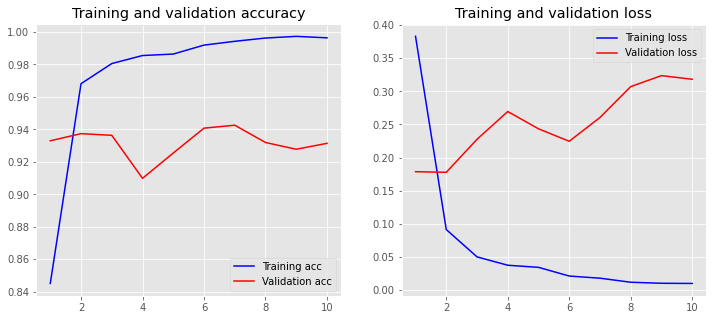

In [27]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) +1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline
plot_history(history)
  

#Export Model

In [28]:
model.save('model.h5')
print('Model has created!')

Model has created!


#Testing Model

In [32]:
input_text = """ 
bersyukur..,,;,;
"""

sentiment = ['negative', 'neutral', 'positive']

text = [preprocess(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 0s 161ms/step
Text:   bersyukur 
Sentiment:  positive
